# Semi-Supervised BERT with Deep Clustering Pre-training

In [1]:
!pip install transformers==3.0.0

     |████████████████████████████████| 757kB 19.4MB/s 
     |████████████████████████████████| 3.0MB 51.3MB/s 
     |████████████████████████████████| 901kB 49.7MB/s 
     |████████████████████████████████| 1.2MB 55.6MB/s 


In [2]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")     

Mounted at /content/drive


In [4]:
import pandas as pd
df = pd.read_csv('drive/My Drive/DL-Final-Project/Dataset/FINAL_DATASET_NOHASHTAGS_2.csv',  lineterminator='\n')


In [5]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tweets = df.Tweets.values
labels = df.Labels.values
labels[labels==-1] = 0

In [6]:
import numpy as np

freq = np.array(labels)
zeros = np.where(freq == 0, 1, 0)
zeros = zeros.sum()
ones = np.where(freq == 1, 1, 0)
ones = ones.sum()

In [ ]:
max_len = 0

# For every sentence...
for tweet in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

import torch
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was n

Max sentence length:  45


Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to

Original:  aurora cardiovascular services shah prakash d md is rated gununfriendly kenosha wisconsin 2afriendly 
Token IDs: tensor([  101, 13158, 22935,  2578,  7890, 22233,  1040,  9108,  2003,  6758,
         3282,  4609, 19699,  9013, 18718,  6358, 17369,  2050,  5273, 23409,
        19699,  9013, 18718,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

7,806 training samples
2,230 validation samples
1,116 test samples


# Load in Saved Data Splits

In [7]:
from torch.utils.data import TensorDataset, random_split
train_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/train_tokenized.pt')
val_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/valid_tokenized.pt')
test_dataset = torch.load('drive/My Drive/DL-Final-Project/Dataset/Train_Valid_Test/test_tokenized.pt')

In [8]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [9]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model_new = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model_new.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Analysis of Embeddings Before Unsupervised

In [ ]:
embeddings = []
for batch in test_dataloader:
    b_input_ids = batch[0]
    b_input_mask = batch[1]
    batch = b_input_ids.to(device)
    batch_mask = b_input_mask.to(device)
    outputs = model_new(batch, 
                                token_type_ids=None, 
                                attention_mask=batch_mask)
    hidden_states = outputs[1][0][:,-4:,:].mean(dim=1)
    output = hidden_states
    embeddings.append(output.detach().cpu())
final = torch.cat(embeddings).numpy() 

In [ ]:
labels = []
for batch in test_dataloader:
  label = batch[2]
  labels.append(label)
labels = torch.cat(labels).numpy() 

In [10]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(final)
reduced_sne = TSNE(n_components=2).fit_transform(embeddings_reduced)

In [ ]:
sneDF = pd.DataFrame(data = reduced_sne
             , columns = ['principal component 1', 'principal component 2'])
sneDF_final = pd.concat([sneDF, pd.Series(labels)], axis = 1)

In [ ]:
sneDF_final[0].replace({1: "Rights", 0: "Control"}, inplace = True)

In [ ]:
sneDF_final.columns = ['Component 1', 'Component 2', 'Class']

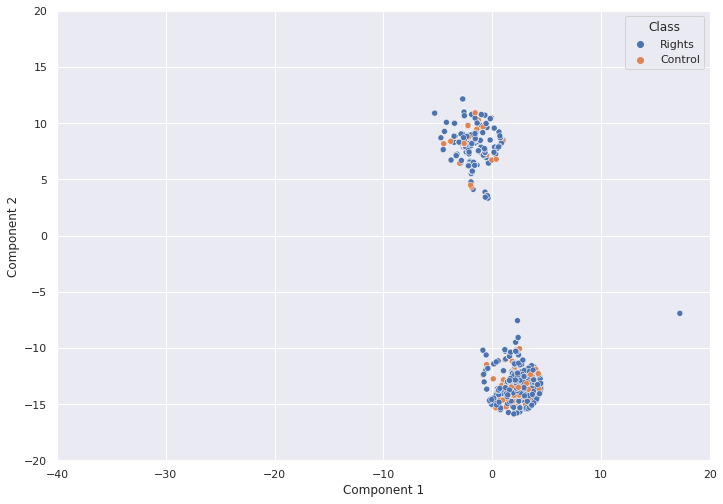

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
plt.ylim(-20, 20)
plt.xlim(-40, 20)
sns.scatterplot(data = sneDF_final, x = "Component 1", y = "Component 2", hue = "Class")

# Pretraining the Model with Unsupervised Learning

In [11]:
optimizer = AdamW(model_new.parameters(),
                  lr = 0.001, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [12]:
from pathlib import Path

from tqdm import tqdm
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms as T
from torchvision.utils import make_grid
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors

In [13]:
pca_dim = 50
kmeans_clusters = 2

# convnet
batch_size = 64
num_classes = 2
num_epochs = 10

In [14]:
from sklearn.mixture import GaussianMixture
pca = PCA(n_components=pca_dim)
#gmm = GaussianMixture(n_components=2, random_state=0) #tried GMM but produced the same results
kmeans = MiniBatchKMeans(n_clusters=kmeans_clusters, batch_size=512, init_size=3*kmeans_clusters)

In [15]:
def extract_features(model, dataset, batch_size=64):
    """
    Gets the output of a pytorch model given a dataset.
    """
    loader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
    
    features = []
    for batch in loader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        batch = b_input_ids.to(device)
        batch_mask = b_input_mask.to(device)
        outputs = model(batch, 
                                   token_type_ids=None, 
                                   attention_mask=batch_mask)
        hidden_states = outputs[1][0][:,-4:,:].mean(dim=1)
        output = hidden_states
        features.append(output.detach().cpu())
    return torch.cat(features).numpy() 

In [16]:
import statistics
def cluster(pca, kmeans, model, dataset, batch_size, return_features=False):
    features = extract_features(model, dataset, batch_size)  
    reduced = pca.fit_transform(features)
    reduced = TSNE(n_components=2).fit_transform(reduced)
    pseudo_labels = list(kmeans.fit_predict(reduced))
    one_count = pseudo_labels.count(1)
    zero_count = pseudo_labels.count(0)
    print("one_count")
    print(one_count)
    print("zero count")
    print(zero_count)
    if one_count == 0:
      randomlist = random.sample(range(0, len(pseudo_labels)), len(pseudo_labels)/ 4)
      for i in randomlist:
        print(i)
        pseudo_labels[i] = 1
    elif zero_count == 0:
      randomlist = random.sample(range(0, len(pseudo_labels)), len(pseudo_labels)/ 4)
      for i in randomlist:
        pseudo_labels[i] = 0
  
    if return_features:
        return pseudo_labels, features
    return pseudo_labels

In [19]:
def train_epoch(model, optimizer, dataset, batch_size = 64):
    loader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        labels = batch[2]
        labels = labels.to(device)
        batch = b_input_ids.to(device)
        batch_mask = b_input_mask.to(device)
        outputs = model(batch, 
                                   token_type_ids=None, 
                                   attention_mask=batch_mask)
        

        hidden_states = outputs[1][0][:,-4:,:].mean(dim=1)
        out = hidden_states
        loss = F.cross_entropy(out, torch.squeeze(labels.long()))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(total_loss)

In [20]:
for i in range(6):
    pseudo_labels = cluster(pca, kmeans, model_new, train_dataset, 64) # generate labels
    pseudo_labels = torch.unsqueeze(torch.tensor(pseudo_labels), 1)
    dataset = TensorDataset(train_dataset[:][0], train_dataset[:][1], pseudo_labels)
    train_dataset = dataset
    labeled_dataset = train_dataset
    train_epoch(model_new, optimizer, labeled_dataset, 64) # train for one epoch

one_count
5932
zero count
5926
337.0304076075554
one_count
5927
zero count
5931
129.95037227869034
one_count
5924
zero count
5934
129.55178314447403
one_count
5930
zero count
5928
129.48265886306763
one_count
5933
zero count
5925
129.32426273822784
one_count
5926
zero count
5932
129.70972269773483


# Looking at Embeddings after Deep Clustering

In [ ]:
torch.save(model_new, 'drive/My Drive/DL-Final-Project/Models/Deep_Clustering_AfterUnsupervised_5_6.pt')

In [ ]:
model_new = torch.load('drive/My Drive/DL-Final-Project/Models/Deep_Clustering_AfterUnsupervised_5_6.pt')

In [21]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
embeddings = []
for batch in test_dataloader:
    b_input_ids = batch[0]
    b_input_mask = batch[1]
    batch = b_input_ids.to(device)
    batch_mask = b_input_mask.to(device)
    outputs = model_new(batch, 
                                token_type_ids=None, 
                                attention_mask=batch_mask)
    hidden_states = outputs[1][0][:,-4:,:].mean(dim=1)
    output = hidden_states
    embeddings.append(output.detach().cpu())
final = torch.cat(embeddings).numpy() 

In [ ]:
labels = []
for batch in test_dataloader:
  label = batch[2]
  labels.append(label)
labels = torch.cat(labels).numpy() 

In [ ]:
from sklearn.manifold import TSNE
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(final)
reduced_sne = TSNE(n_components=2).fit_transform(embeddings_reduced)

In [ ]:
sneDF = pd.DataFrame(data = reduced_sne
             , columns = ['component ', 'principal component 2'])
sneDF_final = pd.concat([sneDF, pd.Series(labels)], axis = 1)

In [ ]:
sneDF_final[0].replace({1: "Rights", 0: "Control"}, inplace = True)
sneDF_final.columns = ['Component 1', 'Component 2', 'Class']

In [ ]:
sneDF_final

,Component 1,Component 2,Class
0,-7.379893,0.361075,Rights
1,-7.829533,-0.116455,Control
2,10.915127,-0.150330,Rights
3,-7.908297,-0.145010,Rights
4,-8.094139,0.110205,Rights
...,...,...,...
2537,10.912460,-0.071479,Control
2538,10.884447,-0.117457,Rights
2539,-7.901408,-0.757250,Rights
2540,-8.128142,0.054851,Rights


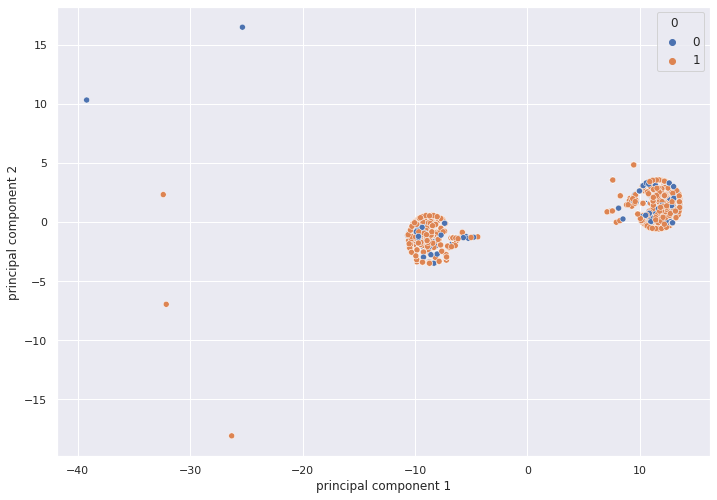

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
sns.scatterplot(data = sneDF_final, x = "Component 1", y = "Component 2", hue = "Class")

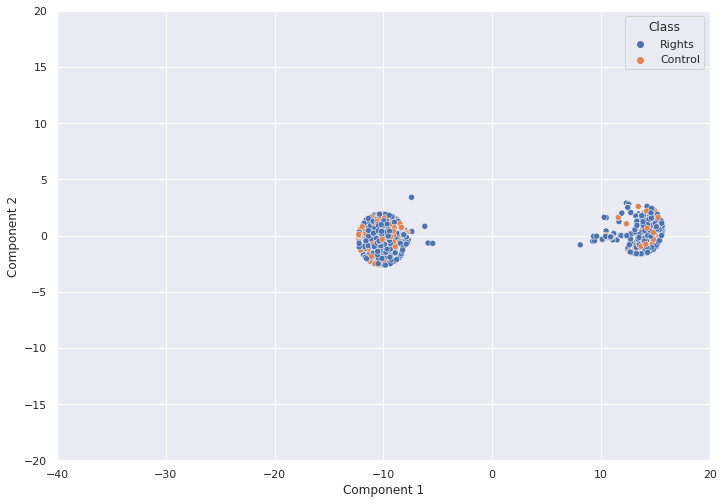

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
plt.ylim(-20, 20)
plt.xlim(-40, 20)
sns.scatterplot(data = sneDF_final, x = "Component 1", y = "Component 2", hue = "Class")

# Fine Tune on Validation Set

In [21]:
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
optimizer = AdamW(model_new.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
import random
import numpy as np
import torch.nn as nn

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
weight = torch.tensor([zeros, ones])
weight = weight / torch.sum(weight)
weight = 1 / weight
weight = weight / torch.sum(weight)
weight = weight.unsqueeze(0)
loss_fn = nn.CrossEntropyLoss(weight = weight.to(device))
#loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([1/zeros, 1/ones]).float().to(device))
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, 6):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model_new.train()

    # For each batch of training data...
    for step, batch in enumerate(validation_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model_new.zero_grad()        

        output = model_new(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        logits = output[1]
        
        loss = loss_fn(logits, b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_new.parameters(), 1.0)
        optimizer.step()
        #scheduler.step()


    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

        # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model_new.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in test_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          output = model_new(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        logits = output[1]
        loss = loss_fn(logits, b_labels)  
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
        

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:11.

  Average training loss: 0.10
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.37
  Validation took: 0:00:07

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:11.

  Average training loss: 0.06
  Training epcoh took: 0:00:22

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.76
  Validation took: 0:00:07

======== Epoch 3 / 6 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:11.

  Average training loss: 0.05
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.58
  Validation took: 0:00:07

======== Epoch 4 / 6 ========
Training...
  Batch    40  of    371.    Elapsed: 0:00:11.

  Average training loss: 0.02
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.90
  Validation Loss: 1.01
  Validation took: 0:00:07

======== Epoch 5 / 6 ======

Test Set Evaluation

In [25]:
# For each epoch...

t0 = time.time()
model_new.eval()

    # Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

    # Evaluate data for one epoch
for batch in test_dataloader:
       
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
        
    with torch.no_grad():        
      output = model_new(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    logits = output[1]
    loss = loss_fn(logits, b_labels)  
    total_eval_loss += loss.item()

        # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
avg_test_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

    # Calculate the average loss over all of the batches.
avg_test_loss = total_eval_loss / len(test_dataloader)
    
    # Measure how long the validation run took.
test_time = format_time(time.time() - t0)
    
print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))

   

  Accuracy: 0.90
  Test Loss: 1.35
  Test took: 0:00:07


In [ ]:
    model_new.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    labels = []
    predictions = []
    # Evaluate data for one epoch
    for batch in test_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          output = model_new(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        logits = output[1]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions = np.concatenate((predictions, pred_flat))
        labels = np.concatenate((labels, label_ids))
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.

In [ ]:
from sklearn.metrics import confusion_matrix
cfs = confusion_matrix(labels, predictions)

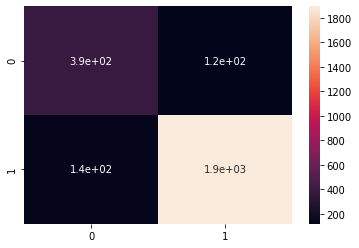

In [ ]:
import seaborn as sns
sns.heatmap(cfs, annot=True)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.74      0.76      0.75       509
     class 1       0.94      0.93      0.94      2033

    accuracy                           0.90      2542
   macro avg       0.84      0.85      0.84      2542
weighted avg       0.90      0.90      0.90      2542



# Visualize After Fine Tuning

In [ ]:
model_new = torch.load('drive/My Drive/DL-Final-Project/Models/Deep_Clustering_5_6_Final.pt')

In [ ]:
embeddings = []
for batch in test_dataloader:
    b_input_ids = batch[0]
    b_input_mask = batch[1]
    batch = b_input_ids.to(device)
    batch_mask = b_input_mask.to(device)
    outputs = model_new(batch, 
                                token_type_ids=None, 
                                attention_mask=batch_mask)
    hidden_states = outputs[1][0][:,-4:,:].mean(dim=1)
    output = hidden_states
    embeddings.append(output.detach().cpu())
final = torch.cat(embeddings).numpy() 

In [ ]:
labels = []
for batch in test_dataloader:
  label = batch[2]
  labels.append(label)
labels = torch.cat(labels).numpy() 

In [ ]:
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(final)
reduced_sne = TSNE(n_components=2).fit_transform(embeddings_reduced)

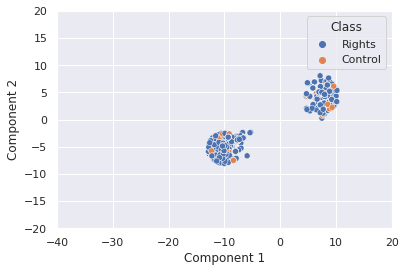

In [ ]:
sneDF_2 = pd.DataFrame(data = reduced_sne
             , columns = ['principal component 1', 'principal component 2'])
sneDF_final_2 = pd.concat([sneDF_2, pd.Series(labels)], axis = 1)
sneDF_final_2[0].replace({1: "Rights", 0: "Control"}, inplace = True)
sneDF_final_2.columns = ['Component 1', 'Component 2', 'Class']
sns.set_theme()
plt.ylim(-20, 20)
plt.xlim(-40, 20)
sns.scatterplot(data = sneDF_final_2, x = "Component 1", y = "Component 2", hue = "Class")

In [ ]:
sneDF = pd.DataFrame(data = reduced_sne
             , columns = ['principal component 1', 'principal component 2'])
sneDF_final = pd.concat([sneDF, pd.Series(labels)], axis = 1)
#sneDF_final = pd.concat([sneDF, pd.Series(predictions)], axis = 1)

In [ ]:
sneDF_final[0].replace({1: "Rights", 0: "Control"}, inplace = True)
sneDF_final.columns = ['Component 1', 'Component 2', 'Class']

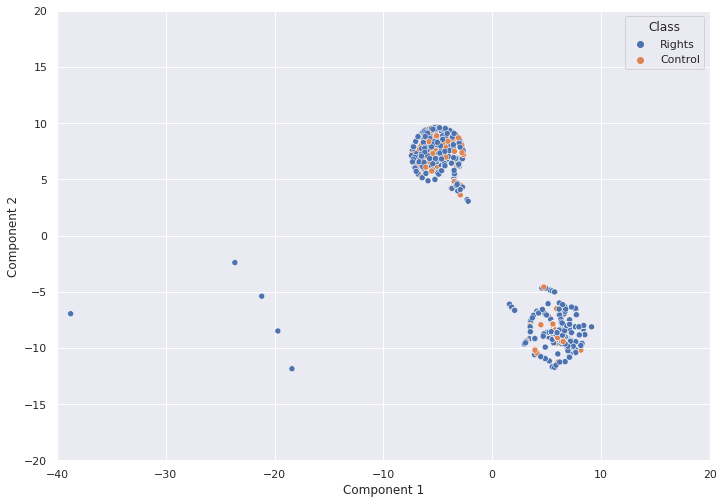

In [ ]:
import seaborn as sns
sns.set_theme()
plt.ylim(-20, 20)
plt.xlim(-40, 20)
sns.scatterplot(data = sneDF_final, x = "Component 1", y = "Component 2", hue = "Class")

In [ ]:
torch.save(model_new, 'drive/My Drive/DL-Final-Project/Models/Deep_Clustering_5_6_Final.pt')

In [ ]:
model_new_loaded = torch.load('drive/My Drive/DL-Final-Project/Models/Deep_Clustering_5_5.pt')

## Evaluation with the loaded model on the test dataset

In [ ]:
    model_new_loaded.eval()
    
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    labels = []
    predictions = []
    # Evaluate data for one epoch
    for batch in test_dataloader:
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
          output = model_new_loaded(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        logits = output[1]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
        predictions = np.concatenate((predictions, pred_flat))
        labels = np.concatenate((labels, label_ids))

In [ ]:
from sklearn.metrics import confusion_matrix
cfs = confusion_matrix(labels, predictions)

## Confusion matrix heatmap

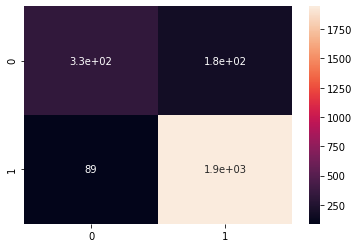

In [ ]:
import seaborn as sns
sns.heatmap(cfs, annot=True)